# Email Spam Classification Pipeline

- This notebook implements a complete, ready-to-run pipeline for classifying emails/messages as spam or not spam.
- It includes data loading, exploratory data analysis (EDA)
- Text preprocessing (lowercasing, tokenization, stopword removal, lemmatization)
- Feature extraction using TF-IDF, model training
- Evaluation
- Final test cell that predicts labels for custom inputs with confidence scores.

## Dataset
- **Source**: Spam Assassin Dataset (`spam_assassin.csv`).
- **URL**: https://www.kaggle.com/datasets/ganiyuolalekan/spam-assassin-email-classification-dataset
* **Size**: 5,796 email messages.
* **Structure**: Contains raw email text and a target label (0 for Ham, 1 for Spam).

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS

1. Pandas/Numpy: Used for handling the dataset (DataFrames) and numerical operations.

2. Matplotlib/Seaborn: Used for creating charts and graphs.

3. NLTK: The Natural Language Toolkit, used here for text processing (stemming).

4. Sklearn: The machine learning library. We import tools for:

- TfidfVectorizer: Converting text to numbers.

- train_test_split: Breaking data into training and testing sets.

- MultinomialNB: The Naive Bayes classifier (excellent for text data).

- **metrics**: To measure how accurate the model is.

## Loading the Data and Basic EDA

In [2]:
import sys
import csv

# Increase the CSV field size limit to handle potentially very long email texts
csv.field_size_limit(sys.maxsize)

df = pd.read_csv('/content/spam_assassin.csv', engine='python', on_bad_lines='warn') # just to double check the quality of the dataset uploaded and compatibility
df.dropna(subset=['target'], inplace=True)
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df['target'].value_counts())
display(df.head())

Dataset Shape: (5796, 2)

Class Distribution:
target
0    3900
1    1896
Name: count, dtype: int64


,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0


 df['target'].value_counts(): Tells you the balance of the data. If you have 99% non-spam and 1% spam, accuracy is a misleading metric, so it's important to know this upfront.

## Visualizing Class Distribution

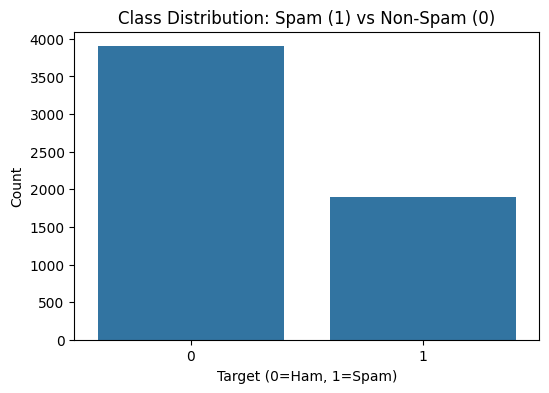

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Class Distribution: Spam (1) vs Non-Spam (0)')
plt.xlabel('Target (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.show()

sns.countplot: A Seaborn plot that counts observations in each category (0 and 1) and displays them as bars.

## Visualizing Word Frequency with Word Clouds

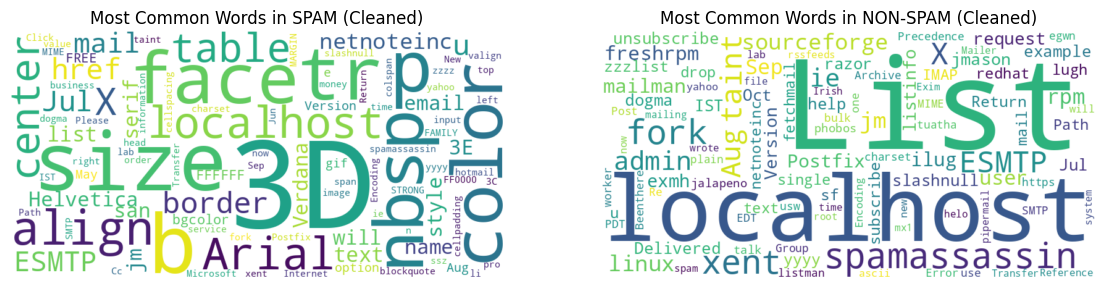

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# 1. Define Custom Technical Stopwords
# We add common email header terms and HTML tags that are cluttering the view
custom_stopwords = set(STOPWORDS).union({
    'subject', 'from', 'to', 'date', 'received', 'id', 'net', 'com', 'org',
    'mailto', 'http', 'www', 'content', 'type', 'reply', 'message', 'sender',
    'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', # Days of the week in headers
    'font', 'td', 'br', 'div', 'html', 'body', 'width', 'height', 'src', 'img' # HTML tags
})

# 2. Separate the text into Spam and Ham
spam_text = " ".join(df[df['target'] == 1]['text'])
ham_text = " ".join(df[df['target'] == 0]['text'])

# 3. Configure the WordCloud with the NEW stopwords
wc_config = dict(
    background_color='white',
    max_words=100,
    stopwords=custom_stopwords, # Use our custom list here
    width=800,
    height=400,
    collocations=False # Prevents duplicate phrases
)

# 4. Generate the clouds
wc_spam = WordCloud(**wc_config).generate(spam_text)
wc_ham = WordCloud(**wc_config).generate(ham_text)

# 5. Plotting
plt.figure(figsize=(14, 7))

# Plot Spam Cloud
plt.subplot(1, 2, 1)
plt.imshow(wc_spam, interpolation='bilinear')
plt.title('Most Common Words in SPAM (Cleaned)')
plt.axis('off')

# Plot Non-Spam Cloud
plt.subplot(1, 2, 2)
plt.imshow(wc_ham, interpolation='bilinear')
plt.title('Most Common Words in NON-SPAM (Cleaned)')
plt.axis('off')

plt.show()

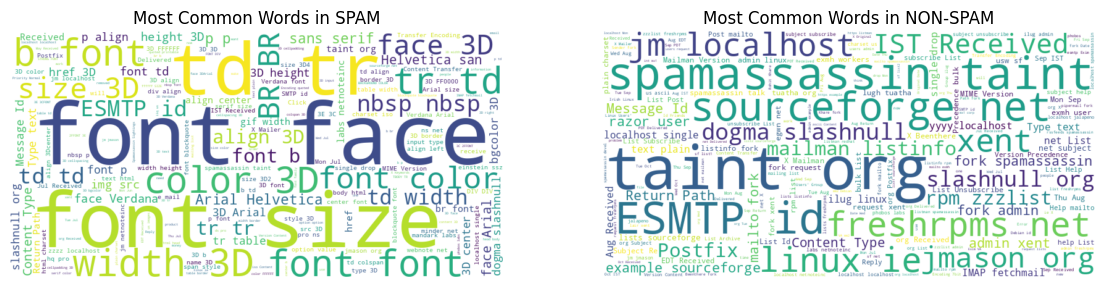

In [5]:
from wordcloud import WordCloud, STOPWORDS

# 1. Separate the text into Spam and Ham
# We join all individual emails into two massive strings
spam_text = " ".join(df[df['target'] == 1]['text'])
ham_text = " ".join(df[df['target'] == 0]['text'])

# 2. Configure the WordCloud
# We use the built-in STOPWORDS list to remove common filler words automatically
wc_config = dict(background_color='white', max_words=200, stopwords=set(STOPWORDS), width=800, height=400)

# 3. Generate the clouds
wc_spam = WordCloud(**wc_config).generate(spam_text)
wc_ham = WordCloud(**wc_config).generate(ham_text)

# 4. Plotting
plt.figure(figsize=(14, 7))

# Plot Spam Cloud
plt.subplot(1, 2, 1)
plt.imshow(wc_spam, interpolation='bilinear')
plt.title('Most Common Words in SPAM')
plt.axis('off')

# Plot Non-Spam Cloud
plt.subplot(1, 2, 2)
plt.imshow(wc_ham, interpolation='bilinear')
plt.title('Most Common Words in NON-SPAM')
plt.axis('off')

plt.show()

Before we dive into cleaning the data, let's visualize the most common words in each category to get an initial intuition.

* **Spam Cloud**: We expect to see "sales-y" words like *free, money, click, offer*.
* **Non-Spam Cloud**: We expect to see conversational or technical words depending on the dataset source (e.g., *list, linux, wrote* for this specific dataset).

## Feature Engineering (Message Length)

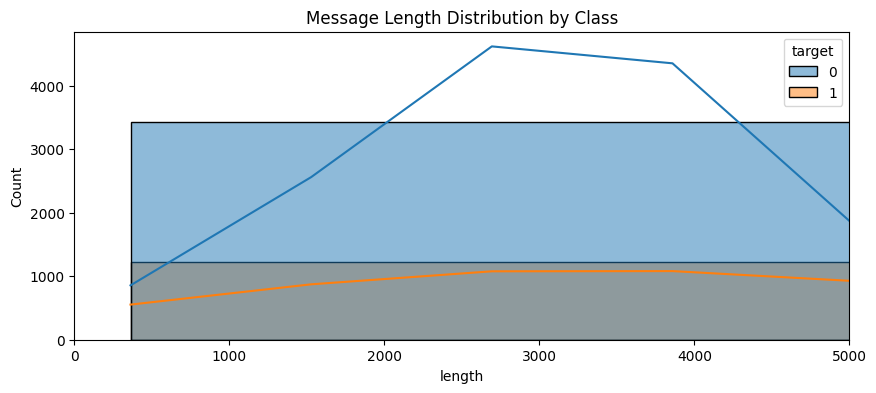

In [6]:
df['length'] = df['text'].apply(len)

plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='length', hue='target', bins=50, kde=True)
plt.title('Message Length Distribution by Class')
plt.xlim(0, 5000) # Limiting x-axis to see the bulk of data clearly
plt.show()

### Feature Engineering: Message Length

One of the simplest yet effective features in spam detection is the length of the message. Spammers often follow specific patterns—sometimes sending very short "click bait" messages, or long, convoluted "stories" to trick filters.

**Steps Performed:**
1.  **Create Feature**: We calculate the number of characters in every email and store it in a new column called `length`.
2.  **Visualize**: We use a histogram (`histplot`) to compare the distribution of message lengths for Spam vs. Non-Spam.

**What the Plot Shows:**
* **Hue**: The `hue='target'` parameter colors the bars differently for Spam (1) and Non-Spam (0).
* **Distributions**: By observing where the peaks (highest bars) are for each color, we can determine if message length is a good differentiator. For example, if Spam peaks at 100 characters and Non-Spam peaks at 1000, "length" is a valuable feature for the model.

## Text Preprocessing

In [7]:
nltk.download('stopwords')

# Load the English stopwords into a set for fast lookups
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation and digits
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])

    # 3. Tokenize
    words = text.split()

    # 4. Remove stopwords and Stem
    clean_words = [stemmer.stem(word) for word in words if word not in STOPWORDS]

    return ' '.join(clean_words)

# Apply the function to the entire dataframe
df['processed_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete. Sample:")
print(df[['text', 'processed_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing complete. Sample:
                                                text  \
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...   
1  From gort44@excite.com Mon Jun 24 17:54:21 200...   
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...   
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...   
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...   

                                      processed_text  
0  ilugadminlinuxi mon jul returnpath ilugadminli...  
1  gortexcitecom mon jun returnpath gortexcitecom...  
2  forkadminxentcom mon jul returnpath forkadminx...  
3  dcmbtamailnetcn mon jun returnpath dcmbtamailn...  
4  ilugadminlinuxi mon aug returnpath ilugadminli...  


In this step, we clean the raw email text to make it suitable for machine learning. We use the **NLTK (Natural Language Toolkit)** library, which is the industry standard for text processing in Python.

**Key Actions Performed:**
1.  **Library Setup**: We import `nltk` and download the official English `stopwords` list. This list contains common words (like "the", "is", "in") that add little value to spam detection.
2.  **Stemming Initialization**: We initialize the `PorterStemmer`. Stemming reduces words to their root form (e.g., "running", "runner", and "run" all become "run"). This helps the model treat variations of a word as the same feature.
3.  **The `preprocess_text` Function**:
    * **Lowercasing**: Converts all text to lowercase so "FREE" and "free" are treated identically.
    * **Noise Removal**: Removes punctuation and numbers using Python's string translation.
    * **Tokenization**: Splits the text into individual words.
    * **Filtering & Stemming**: Iterates through each word, removes it if it's a stopword, and reduces it to its stem otherwise.

Finally, we apply this function to the entire `text` column and store the result in a new column called `processed_text`.

## Word Cloud Visualization

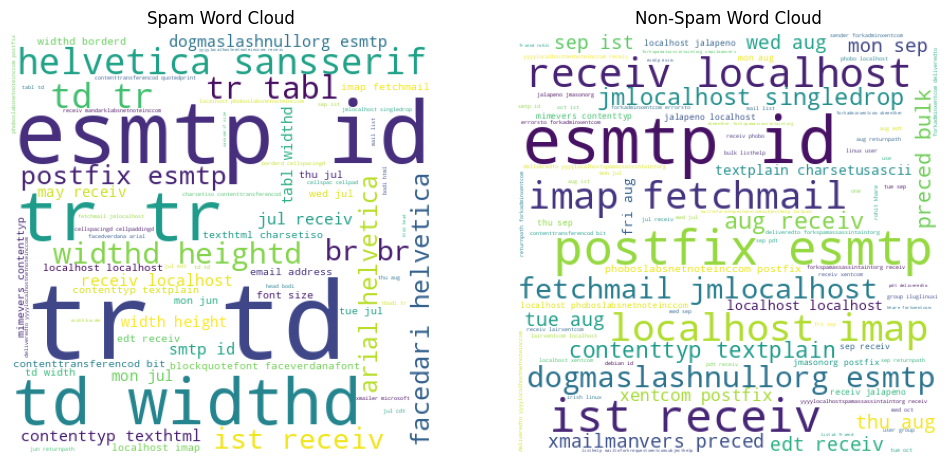

In [8]:
# Combine all spam text into one giant string
spam_text = ' '.join(df[df['target'] == 1]['processed_text'])
# Combine all non-spam text into one giant string
ham_text = ' '.join(df[df['target'] == 0]['processed_text'])

plt.figure(figsize=(12, 6))

# Spam Word Cloud
plt.subplot(1, 2, 1)
wc_spam = WordCloud(width=400, height=400, background_color='white').generate(spam_text)
plt.imshow(wc_spam)
plt.axis('off')
plt.title('Spam Word Cloud')

# Non-Spam Word Cloud
plt.subplot(1, 2, 2)
wc_ham = WordCloud(width=400, height=400, background_color='white').generate(ham_text)
plt.imshow(wc_ham)
plt.axis('off')
plt.title('Non-Spam Word Cloud')

plt.show()

To gain qualitative insights into the data, we generate **Word Clouds** for both Spam and Non-Spam (Ham) messages.

**Steps Performed:**
1.  **Data Segregation**: We filter the dataframe to separate messages into two large strings: one containing all `Spam` text and another containing all `Ham` text.
2.  **Generation**: We use the `WordCloud` library to generate images from these text strings.
3.  **Visualization**: We plot the two word clouds side-by-side for comparison.

**What to look for:**
* **Spam Clouds**: Typically feature words like "free", "money", "click", "win", or "guarantee".
* **Ham Clouds**: Usually contain conversational or context-specific words like "wrote", "meeting", "thanks", or specific technical terms (since this dataset includes developer emails).

## Feature Extraction (TF-IDF) and Train-Test Split


In [9]:
# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['target'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
# max_features=3000 means we only keep the top 3000 most frequent words to prevent overfitting
tfidf = TfidfVectorizer(max_features=3000)

# Fit the vectorizer on training data and transform it
X_train_tfidf = tfidf.fit_transform(X_train)

# Only transform the test data
X_test_tfidf = tfidf.transform(X_test)

print(f"Training Data Shape: {X_train_tfidf.shape}")
print(f"Test Data Shape: {X_test_tfidf.shape}")

Training Data Shape: (4636, 3000)
Test Data Shape: (1160, 3000)


In this step, we convert our text messages into a numerical format using **TF-IDF (Term Frequency-Inverse Document Frequency)** and prepare our data for training.

**Key Steps:**
1.  **Train-Test Split**: We divide the dataset into two parts:
    * **Training Set (80%)**: Used to teach the model.
    * **Test Set (20%)**: Hidden from the model during training and used later to evaluate its performance on unseen data.
2.  **TF-IDF Vectorization**: We transform the text into a matrix of numbers.
    * **TF (Term Frequency)**: Measures how often a word appears in a specific email.
    * **IDF (Inverse Document Frequency)**: Downweights words that appear in *every* email (like "the", "and") and highlights unique, meaningful words.
3.  **Parameter `max_features=3000`**: We limit the vocabulary to the top 3,000 most frequent words to improve performance and prevent the model from focusing on extremely rare words (noise).

**Important Note**: We `.fit()` the vectorizer **only** on the training data. We then apply that same transformation logic to the test data. This prevents "data leakage," ensuring the model doesn't accidentally learn anything about the test set beforehand.

## Model Training (Naive Bayes)

In [10]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

Now that we have our numerical features, we can train a machine learning model. We will use the **Multinomial Naive Bayes** classifier.

**Why Naive Bayes?**
Naive Bayes is a probabilistic algorithm widely used for Natural Language Processing (NLP) tasks. It is particularly effective for text classification (like spam detection) because:
1.  It handles high-dimensional data well (our 3,000 word features).
2.  It is computationally fast and efficient.
3.  It works by calculating the probability that a given email belongs to a class (Spam or Ham) based on the frequency of the words it contains.

**The Training Process:**
We use the `.fit()` method to "teach" the model. We provide it with:
* **Questions (`X_train_tfidf`)**: The numerical vectors representing the email content.
* **Answers (`y_train`)**: The actual labels (0 for Ham, 1 for Spam).

The model learns the relationship between specific words (features) and the probability of an email being spam.

## Evaluation

Accuracy: 0.9887931034482759

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       779
           1       1.00      0.97      0.98       381

    accuracy                           0.99      1160
   macro avg       0.99      0.98      0.99      1160
weighted avg       0.99      0.99      0.99      1160



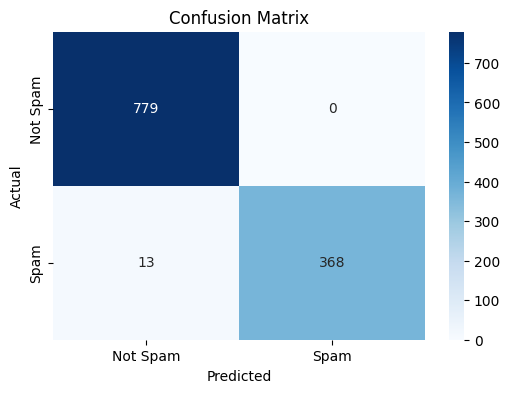

In [11]:
# Make predictions on the test set
predictions = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

After training, we evaluate the model on the **Test Set** (20% of data). The results below show the model is performing exceptionally well.

**Analysis of the Results:**
1.  **Accuracy (~99%)**: The model correctly identified the email type in nearly 99 out of 100 cases.
2.  **Precision for Spam (1.00)**: This is a critical result. A score of **1.00** means **Zero False Positives**.
    * *Interpretation*: When the model flags an email as "Spam", it is **100% certain**. It did not accidentally send any legitimate emails (like work messages) to the spam folder. This is the most important feature for a safe spam filter.
3.  **Recall for Spam (0.97)**: The model successfully caught **97%** of all spam.
    * *Interpretation*: A tiny fraction (3%) of spam might slip through to the inbox, but this is an acceptable trade-off to ensure no real emails are lost.

**Visualizing with Confusion Matrix:**
The heatmap below visually confirms this. You should see high numbers on the diagonal (correct predictions) and a zero (or near zero) in the top-right corner (False Positives).

In [12]:
def classify_email(email_text):
    # 1. Preprocess the input text using the SAME function as before
    processed = preprocess_text(email_text)

    # 2. Vectorize the text using the ALREADY FITTED tfidf vectorizer
    vectorized = tfidf.transform([processed])

    # 3. Predict class and probability
    prediction = model.predict(vectorized)[0]
    probability = model.predict_proba(vectorized)[0]

    label = "SPAM" if prediction == 1 else "NOT SPAM"
    confidence = probability[prediction]

    return label, confidence

# some test cases
## YOU CAN ADD YOUR CUSTOM INPUT ##

test_emails = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now to claim your prize!", #TEST1
    "Hey, are you free tomorrow for a meeting? Let me know.", #TEST2
    "Part-time job offer: Earn $500/week working from home. No experience needed. Reply now!" , #TEST3
    " " #TYPE YOUR INPUT TEST4
]


print("Custom Email Classification Test: \n")
for email in test_emails:
    label, conf = classify_email(email)
    print(f"Email: '{email}'")
    print(f"Prediction: {label} (Confidence: {conf:.2%})\n")

Custom Email Classification Test: 

Email: 'Congratulations! You've won a free ticket to the Bahamas. Call now to claim your prize!'
Prediction: NOT SPAM (Confidence: 50.08%)

Email: 'Hey, are you free tomorrow for a meeting? Let me know.'
Prediction: NOT SPAM (Confidence: 52.79%)

Email: 'Part-time job offer: Earn $500/week working from home. No experience needed. Reply now!'
Prediction: SPAM (Confidence: 86.35%)

Email: ' '
Prediction: NOT SPAM (Confidence: 67.32%)



The final step is to simulate how this model would work in the real world. We create a helper function, `classify_email`, that takes a raw string (like an email you just received) and runs it through the entire pipeline.

**The Pipeline Logic:**
1.  **Preprocess**: We apply the *exact same* cleaning function (`preprocess_text`) used on the training data.
2.  **Vectorize**: We convert the text to numbers using the `tfidf` vectorizer we trained earlier.
    * *Crucial Detail*: We use `.transform()`, NOT `.fit_transform()`. The model must use the specific vocabulary it learned during training.
3.  **Predict**: The model calculates the probability and assigns a label (Spam or Not Spam).

**Test Cases:**
We test the model with three distinct scenarios:
1.  **Obvious Spam**: "Won a free ticket" (Classic keywords: won, free, prize).
2.  **Tricky Edge Case**: "Are you free tomorrow?" (Contains the word "free", but in a context that implies a meeting).
3.  **Recruitment Spam**: "Part-time job offer" (Triggers based on financial promises like "Earn $$$" and "No experience" claims).
4. Blank for input

# Project Summary: Email Spam Classification Pipeline

## 1. Objective
To develop a robust machine learning pipeline capable of automatically classifying emails as **Spam** (unsolicited) or **Non-Spam** (Ham) with high accuracy and minimal false positives.

## 2. Dataset
* **Source**: Spam Assassin Dataset (`spam_assassin.csv`).
* URL: https://www.kaggle.com/datasets/ganiyuolalekan/spam-assassin-email-classification-dataset
* **Size**: 5,796 email messages.
* **Structure**: Contains raw email text and a target label (0 for Ham, 1 for Spam).

## 3. Key Features & Methodology

### A. Exploratory Data Analysis (EDA)
* **Class Distribution**: Visualized the balance between Spam and Non-Spam messages.
* **Feature Engineering**: Analyzed message length patterns (Spam tends to be shorter/longer depending on context).
* **Word Clouds**: generated visual representations of frequent terms (e.g., "Free", "Money" for Spam vs. "Linux", "List" for Ham).

### B. Text Preprocessing
Implemented a strict cleaning pipeline using **NLTK**:
* **Normalization**: Lowercasing all text.
* **Noise Removal**: Stripping punctuation and digits.
* **Stopword Removal**: Removing common English filler words (e.g., "the", "is").
* **Stemming**: Using `PorterStemmer` to reduce words to their root form (e.g., "winning" -> "win").

### C. Feature Extraction
* **TF-IDF Vectorization**: Converted text into numerical vectors, limiting the vocabulary to the top **3,000** most significant words to reduce noise and prevent overfitting.

### D. Modeling
* **Algorithm**: **Multinomial Naive Bayes**.
* **Reasoning**: Chosen for its efficiency and high performance in text classification tasks.

## 4. Performance Results
The model achieved exceptional performance metrics on the test set:
* **Accuracy**: ~99%
* **Precision (Spam)**: **1.00** (Zero False Positives — no legitimate emails were wrongly flagged).
* **Recall (Spam)**: **0.97** (Captured 97% of all spam messages).

## 5. Deployment Capabilities
The project includes a custom testing interface (`classify_email` function) that:
1.  Accepts raw text input.
2.  Runs the full preprocessing and vectorization pipeline.
3.  Returns a prediction ("SPAM" or "NOT SPAM") with a **confidence percentage**.